In [15]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, output_file, save, show
from bokeh.models.formatters import DatetimeTickFormatter
from bokeh.models import ColumnDataSource, BoxZoomTool, PanTool, ResetTool, HoverTool, WheelZoomTool, Title
import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

# oauth scopes required
scope = [
   'https://spreadsheets.google.com/feeds',
   'https://www.googleapis.com/auth/drive'
]
#Name of our Service Account Key file
google_key_file = '<gsa>.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# worksheet ID from Google Sheet URL
spreadsheet_key = '<secretKey>'
# sheet name
wks_name = 'fcs'
# Read from worksheet (name: fcs) in Google Sheet file by using Worksheet ID/name
workbook = gc.open_by_key(spreadsheet_key)
# Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_name)
# Pulling the data and transform it to the data frame
values = sheet.get_all_values()

df = (pd.DataFrame(values[1:], columns = values[0])
      .replace(r'^\s*$', np.nan, regex=True)
      .fillna(0) # keep NaN, otherwise zeros will influence the mean()
      .apply(pd.to_numeric, errors='ignore') # Convert number strings to floats and ints, Score6 and Score7 are int64 not float64 which causes problems when aplying other functions
      .astype({
         "Score6":"float", # pd.to_numeric converts to int unfortunately, needs to be consistent
         "Score7":"float", # pd.to_numeric converts to int unfortunately, needs to be consistent
     }) # close astype()
     ) # end df

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=['Date'], inplace=True, ascending=True)

print(df.dtypes)

Date           datetime64[ns]
Score1                float64
Score2                float64
Score3                float64
Score4                float64
Score5                float64
Score6                float64
Score7                float64
Vomit                   int64
NoteMedical            object
Note2                  object
Note3                  object
dtype: object


In [16]:
# Set date range for plot
mask = (df['Date'] > '2023-03-14') & (df['Date'] <= '2023-05-29')
# mask = (df['Date'] > '2024-01-20')
df = df.loc[mask]

# create temporary dataframe with NaN. NaN will be skipped by mean()
sub_df = df.replace(0, np.nan)

df['Mean'] = sub_df[["Score1","Score2","Score3","Score4","Score5","Score6","Score7"]].mean(axis=1, skipna=True).round(2)
df['color'] = df.NoteMedical.map(
    lambda x: 'steelblue' if x == 'Atopica' else (
    'forestgreen' if x == 'AfterAtopicaEnd' else 'lightcoral'))
print(df.head())

         Date  Score1  Score2  Score3  Score4  Score5  Score6  Score7  Vomit   
73 2023-03-15     3.0     3.0     0.0     0.0     0.0     0.0     0.0      0  \
74 2023-03-16     4.0     5.5     0.0     0.0     0.0     0.0     0.0      0   
75 2023-03-17     5.5     5.5     0.0     0.0     0.0     0.0     0.0      0   
76 2023-03-18     6.0     6.0     6.0     6.0     6.0     6.0     6.0      0   
77 2023-03-19     6.0     6.0     6.0     6.0     0.0     0.0     0.0      0   

   NoteMedical  Note2 Note3  Mean       color  
73           0      0     0  3.00  lightcoral  
74           0      0     0  4.75  lightcoral  
75           0      0     0  5.50  lightcoral  
76           0      0     0  6.00  lightcoral  
77           0  Aimee     0  6.00  lightcoral  


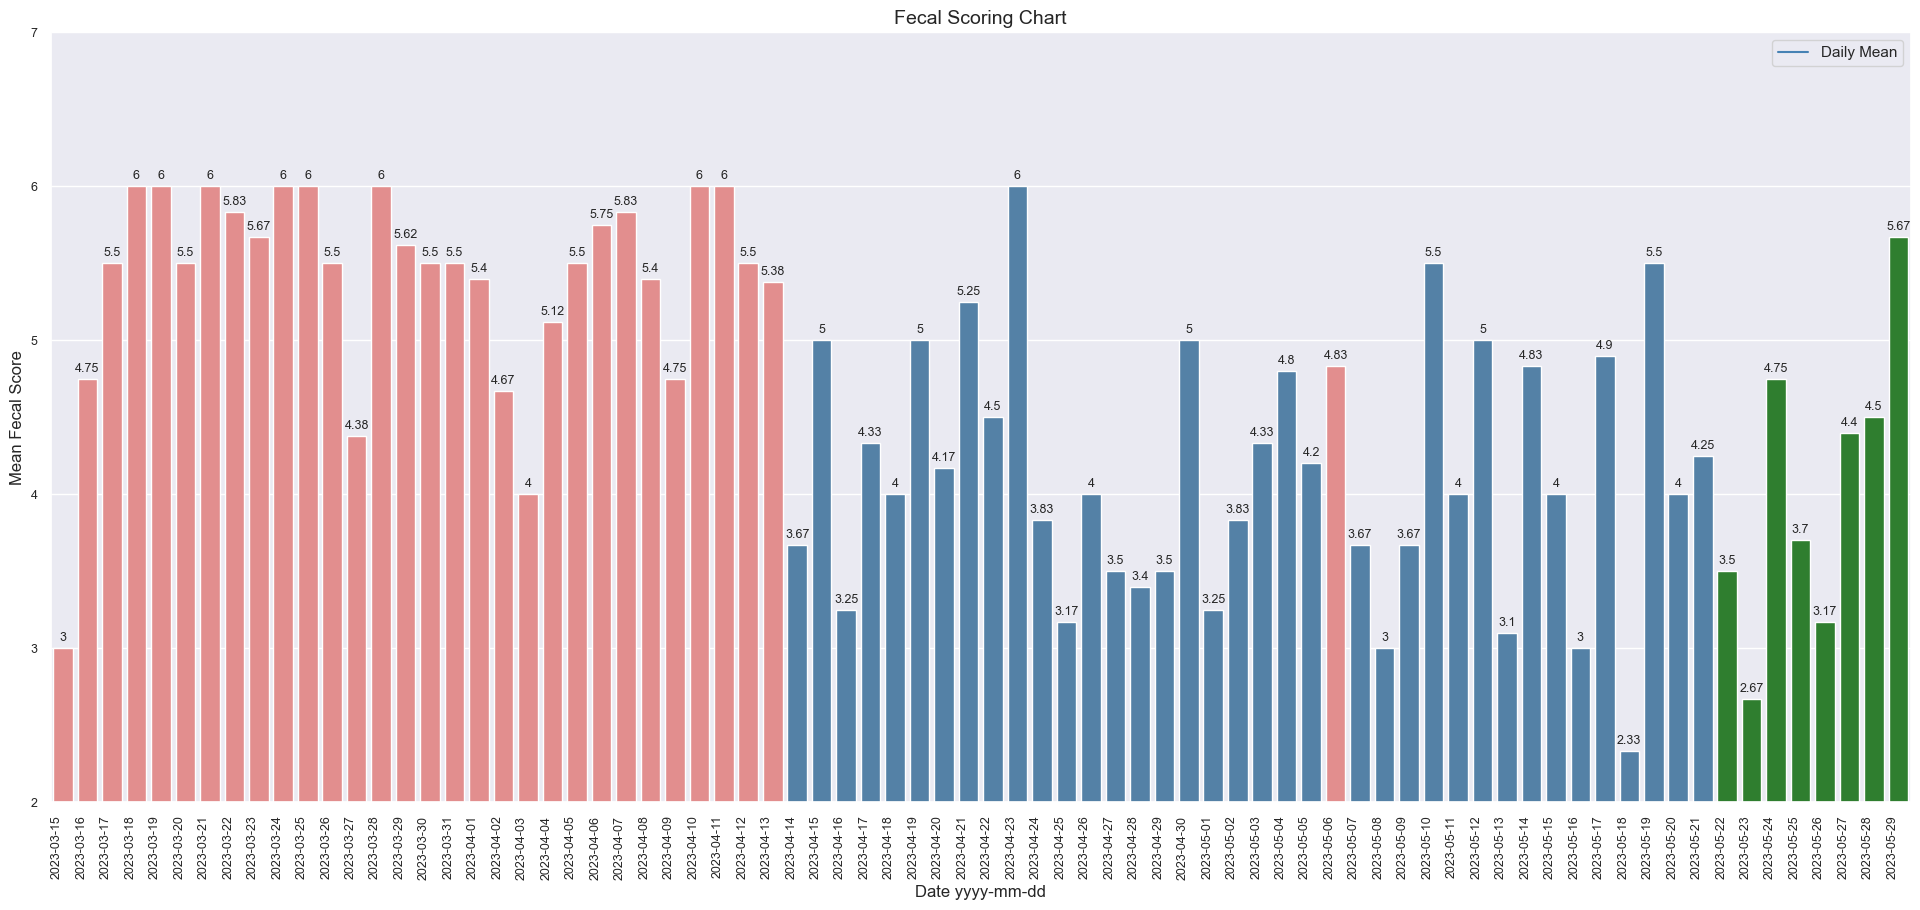

In [17]:
# visualize
from matplotlib.lines import Line2D

a = Line2D([], [], color='steelblue', label='Daily Mean')
b = Line2D([], [], color='green', label='foo')
c = Line2D([], [], color='#BEC647', label='bar')

sns.set() # set the style

plt.figure(figsize=(24,10)) # change width and height of the chart
plt.rcParams['font.size'] = 9 # set the bar_label font size

# bar coloring based on computed df.color column (see previous cell)
graph = sns.barplot(x="Date", y="Mean", data=df, palette=df['color'])

# graph.legend(["Date","Mean"]) # works but pointless? Also, shows black lines in legend box
graph.axes.set_title("Fecal Scoring Chart", fontsize=14)
graph.tick_params(labelsize=9) # set axes label size
graph.bar_label(graph.containers[0], padding=3) # show data values on each bar
graph.set_ylim(2,7) # y-axis limits

x_dates = df['Date'].dt.strftime('%Y-%m-%d').sort_values().unique()
graph.set_xticklabels(labels=x_dates, rotation=90, ha='right')

plt.xlabel('''Date yyyy-mm-dd''')
plt.ylabel('''Mean Fecal Score''')
plt.legend(handles=[a])
plt.savefig('FCS-Exports//EdisonAnderson-FecalScoreChart-2024.png', bbox_inches='tight')
plt.show()

In [18]:
# distribution plot
distribution = (df[["Score1", "Score2", "Score3","Score4","Score5","Score6","Score7"]]
                .apply(pd.Series.value_counts)
                .fillna(0) # replace NaN string
                .drop([0]) # drop meaningless 0.0 row counts
                .sum(axis=1)
               )

distribution.dtypes
print(distribution)

source = ColumnDataSource(df)
print(source.data.keys())



2.0    22.0
2.5     7.0
3.0    30.0
3.5     9.0
4.0    29.0
4.5     6.0
5.0    47.0
5.5    23.0
6.0    90.0
7.0     1.0
dtype: float64
dict_keys(['index', 'Date', 'Score1', 'Score2', 'Score3', 'Score4', 'Score5', 'Score6', 'Score7', 'Vomit', 'NoteMedical', 'Note2', 'Note3', 'Mean', 'color'])


In [19]:
# bokeh plot
# create a plot
plot = figure(title = "Fecal Scoring Chart",
              x_axis_type = 'datetime',
              x_axis_label = 'Date',
              y_axis_label = 'Mean',
              sizing_mode="stretch_width",
              height = 800,
              # source = ColumnDataSource(df), # source is invalid attribute
              tools=[ResetTool(),
                     BoxZoomTool(),
                     WheelZoomTool(dimensions="width"),
                     PanTool(dimensions="width"),
                     HoverTool(tooltips=[('Score', '@y'), ('Date', '$x{%F}'), ('Note2', '@{Note2}'), ('Note3', '@Note3'), ('NoteMedical', '@{NoteMedical}')], formatters={'$x': 'datetime'}),
                    ], # end tools
             # tooltips="Data point @x has the value @y",
             )

# add a renderer
plot.line(x = df['Date'],
          y = df.Mean,
          legend_label = 'Daily Average',
          line_width = 2,
         )

# add extra titles with add_layout(...)
plot.add_layout(Title(text="Welsh Springer Spaniel, male, DOB 2022-01-24", align="center"), "below")

# display legend in top left corner (default is top right corner)
plot.legend.location = "top_right"

# add a title to your legend
plot.legend.title = "Legend"

# add bands to the y-grid
plot.ygrid.band_fill_color = "olive"
plot.ygrid.band_fill_alpha = 0.1

# set output to static HTML file
output_file(filename="bokeh_plot.html", title="Bokeh Fecal Score Chart HTML file")
# Save plot
save(plot)

# Output plot
show(plot)